Dataset - http://archive.ics.uci.edu/ml/datasets/Spambase \
File “spambase.data” contains the actual data, and files “spambase.names” and “spambase.DOCUMENTATION” contain the description of the data. \
This dataset has 4601 records, each record representing a different email message. Each record is described with 58 attributes. \
Attributes 1-57 represent various content-based characteristics already extracted from each email message (related to the frequency of certain words or certain punctuation symbols in a message as well as to the usage of capital letters in a message), and the last attribute represents the class label for each message (spam or non-spam).

We'll build both a best performing model in terms of overall prediction accuracy as well as a cost-sensitive model in terms an average misclassification cost.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from scikitplot.metrics import plot_roc, plot_lift_curve
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('./data/spambase.data', header=None)
values = df.values
X = values[:, :-1]
Y = values[:, -1].astype(np.int64)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=29)

In [14]:
np.bincount(Y)

array([2788, 1813])

In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [16]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4601 non-null   float64
 1   1       4601 non-null   float64
 2   2       4601 non-null   float64
 3   3       4601 non-null   float64
 4   4       4601 non-null   float64
 5   5       4601 non-null   float64
 6   6       4601 non-null   float64
 7   7       4601 non-null   float64
 8   8       4601 non-null   float64
 9   9       4601 non-null   float64
 10  10      4601 non-null   float64
 11  11      4601 non-null   float64
 12  12      4601 non-null   float64
 13  13      4601 non-null   float64
 14  14      4601 non-null   float64
 15  15      4601 non-null   float64
 16  16      4601 non-null   float64
 17  17      4601 non-null   float64
 18  18      4601 non-null   float64
 19  19      4601 non-null   float64
 20  20      4601 non-null   float64
 21  21      4601 non-null   float64
 22  

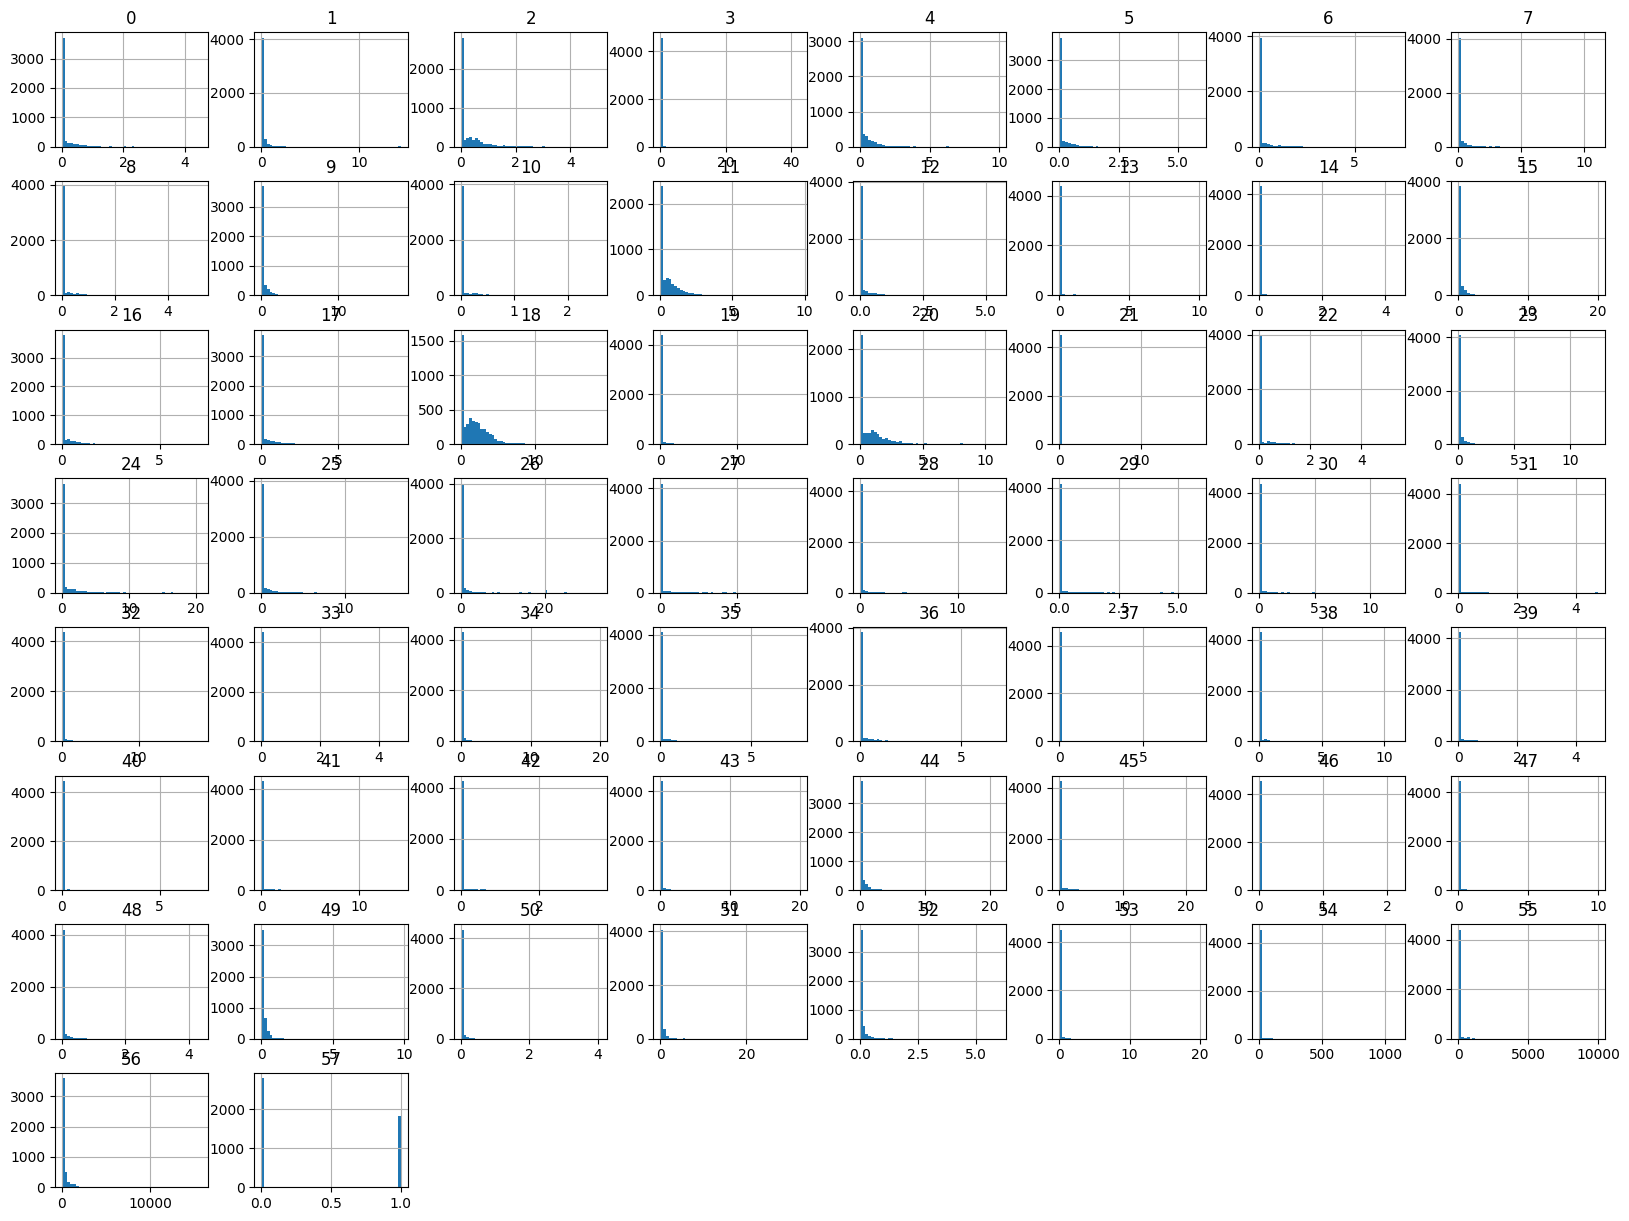

In [18]:
df.hist(bins = 50, figsize=(20,15))
plt.show()

Running all models with normalization

In [12]:
model_names = []

clf1 = LogisticRegression(class_weight='balanced', max_iter=10000)
pipe1 = Pipeline([('std', StandardScaler()), ('clf1', clf1)])
p_grid1 = [{'clf1__C': np.power(10, range(0, 10))}]
model_names.append('Logistic')

clf2 = KNeighborsClassifier()
pipe2 = Pipeline([('std', StandardScaler()), ('clf2', clf2)])
p_grid2 = [{'clf2__n_neighbors': range(1, 10)}]
model_names.append('KNN')

clf3 = DecisionTreeClassifier(class_weight='balanced')
p_grid3 = [{'clf3__max_depth': range(1, 10), 'clf3__criterion': [
    'gini', 'entropy']}]
pipe3 = Pipeline([('std', StandardScaler()), ('clf3', clf3)])
model_names.append('Decision Tree')

clf4 = SVC(class_weight='balanced')
pipe4 = Pipeline([('std', StandardScaler()), ('clf4', clf4)])
p_grid4 = [{'clf4__kernel': ['rbf'], 'clf4__C': np.power(10, range(0, 5)), 'clf4__gamma': np.power(10., range(-5, 0))},
           {'clf4__kernel': ['linear'], 'clf4__C': np.power(10, range(0, 5))}]
model_names.append('SVC')

clf5 = MLPClassifier(random_state=29)
p_grid5 = [{'clf5__activation': ['relu', 'tanh'], 'clf5__solver': ['lbfgs', 'adam'], 
'clf5__hidden_layer_sizes': [(22), (22, 22), (12, 12)]}]
pipe5 = Pipeline([('std', StandardScaler()), ('clf5', clf5)])
model_names.append('Neural Net')

clf6 = XGBClassifier(seed=29, verbosity=0)
p_grid6 = [{'clf6__n_estimators': [100, 500, 1000], 'clf6__max_depth': range(2, 11), 
'clf6__eta': np.power(10., range(-4, 1)), 'clf6__subsample': [0.1, 0.5, 1], 'clf6__colsample_bytree': [0.1, 0.5, 1]}]
pipe6 = Pipeline([('std', StandardScaler()), ('clf6', clf6)])
model_names.append('xgboost')

inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=29)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=29)
grid_cv = []

for p_grid, est in zip((p_grid1, p_grid2, p_grid3, p_grid4, p_grid5, p_grid6), (pipe1, pipe2, pipe3, pipe4, pipe5, pipe6)):
    # gs = GridSearchCV(estimator=est, param_grid=p_grid, scoring='f1', cv=inner_cv)
    gs = RandomizedSearchCV(estimator=est, param_distributions=p_grid,
                            scoring='f1', cv=inner_cv, random_state=29)
    grid_cv.append(gs)


Getting the f1 score averages and standard deviations for all models - Normalized

In [51]:
nested_scores = []
for i in range(len(grid_cv)):
    nested_score = cross_val_score(grid_cv[i], X=x_train, y=y_train, cv=outer_cv, scoring='f1')
    nested_scores.append((model_names[i], nested_score.mean(), nested_score.std()))
nested_scores


[('Logistic', 0.906907589973516, 0.010989850507871988),
 ('KNN', 0.872545101731896, 0.011190827673510987),
 ('Decision Tree', 0.89138703619591, 0.02066604148553987),
 ('SVC', 0.9063246233564621, 0.013268356312041834),
 ('Neural Net', 0.9238779663007578, 0.016738296609973655),
 ('xgboost', 0.9309996597226964, 0.012794762215576436)]

Running all models without normalization

In [149]:

model_names = []

clf1 = LogisticRegression(class_weight='balanced', max_iter=10000)
p_grid1 = [{'C': np.power(10, range(0, 10))}]
model_names.append('Logistic')

clf2 = KNeighborsClassifier()
p_grid2 = [{'n_neighbors': range(1, 11)}]
model_names.append('KNN')

clf3 = DecisionTreeClassifier(class_weight='balanced')
p_grid3 = [{'max_depth': range(1, 10), 'criterion': ['gini', 'entropy']}]
model_names.append('Decision Tree')

clf4 = SVC(class_weight='balanced')
pipe4 = Pipeline([('clf4', clf4)])
p_grid4 = [{'kernel': ['rbf'], 'C': np.power(10, range(0, 5))}]
model_names.append('SVC')

clf5 = MLPClassifier(random_state=29)
p_grid5 = [{'activation': ['relu', 'tanh'], 'solver': ['lbfgs', 'adam'], 'hidden_layer_sizes': [(22), (12, 12)]}]
model_names.append('Neural Net')

clf6 = XGBClassifier(seed=29, verbosity=0)
p_grid6 = [{'n_estimators': [100, 500], 'max_depth': range(2, 11), 'eta': np.power(10., range(-4, 1)),
 'subsample': [0.1, 0.5, 1], 'colsample_bytree': [0.1, 0.5, 1]}]
model_names.append('xgboost')

inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=29)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=29)
grid_cv = []

for p_grid, est in zip((p_grid1, p_grid2, p_grid3, p_grid4, p_grid5, p_grid6), (clf1, clf2, clf3, clf4, clf5, clf6)):
    gs = RandomizedSearchCV(estimator=est, param_distributions=p_grid,
                            scoring='f1', cv=inner_cv, random_state=29)
    grid_cv.append(gs)


Getting the f1 score averages and standard deviations for all models - not normalized

In [53]:
nested_scores = []
for i in range(len(grid_cv)):
    print('Running model: ', model_names[i])
    nested_score = cross_val_score(
        grid_cv[i], X=x_train, y=y_train, cv=outer_cv, scoring='f1')
    nested_scores.append((model_names[i], nested_score.mean(), nested_score.std()))
nested_scores

Running model:  Logistic
Running model:  KNN
Running model:  Decision Tree
Running model:  SVC
Running model:  Neural Net
Running model:  xgboost


[('Logistic', 0.904074163493269, 0.013583584391939801),
 ('KNN', 0.7470062229657407, 0.017212428667095533),
 ('Decision Tree', 0.891104945720582, 0.020414762239344582),
 ('SVC', 0.903827637946389, 0.004057186451202091),
 ('Neural Net', 0.9249881059718108, 0.012204709925032418),
 ('xgboost', 0.9308630231164718, 0.012824894791190236)]

Normalization helps with training faster and improves model performance for non-tree based models <br>
This behavior is as expected <br>

Tuning the hyperparameters for the best model - xgboost

In [151]:
hp_model = RandomizedSearchCV(estimator=clf6, param_distributions=p_grid6, scoring='f1', cv=inner_cv, random_state=29)
hp_model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=29, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None, seed=29,
                                       

In [152]:
best_model = hp_model.best_estimator_
pred = best_model.predict(pd.DataFrame(x_test))
print(classification_report(y_test, pred))
prob = best_model.predict_proba(pd.DataFrame(x_test))
hp_model.best_params_


              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       543
         1.0       0.94      0.93      0.94       378

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



{'subsample': 1,
 'n_estimators': 100,
 'max_depth': 10,
 'eta': 1.0,
 'colsample_bytree': 1}

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

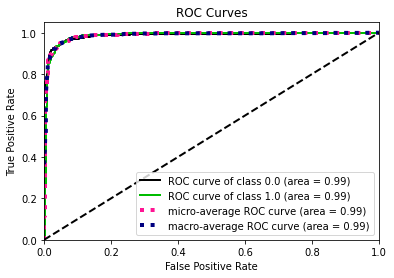

In [62]:
plot_roc(y_test, prob)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

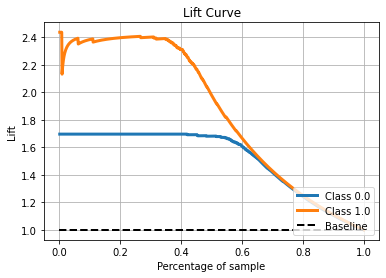

In [63]:
plot_lift_curve(y_test, prob)

Cost-sensitive classification \
Let's assume misclassifying a non-spam email as spam is the costlier with a 10:1 ratio and the costs are calculated accordingly

In [64]:
def missclass_cost(actual, pred):
    cm = confusion_matrix(actual, pred)
    return (10*cm[0,1]+1*cm[1,0])/(len(actual))

In [65]:

model_names = []
scorer = make_scorer(missclass_cost, greater_is_better = False)

clf1 = LogisticRegression(class_weight='balanced', max_iter=10000)
pipe1 = Pipeline([('std', StandardScaler()), ('clf1', clf1)])
p_grid1 = [{'clf1__C': np.power(10, range(0, 10))}]
model_names.append('Logistic')

clf2 = KNeighborsClassifier()
pipe2 = Pipeline([('std', StandardScaler()), ('clf2', clf2)])
p_grid2 = [{'clf2__n_neighbors': range(1, 10)}]
model_names.append('KNN')

clf3 = DecisionTreeClassifier(class_weight='balanced')
p_grid3 = [{'max_depth': range(1, 10), 'criterion': [
    'gini', 'entropy']}]
model_names.append('Decision Tree')

clf4 = SVC(class_weight='balanced')
pipe4 = Pipeline([('std', StandardScaler()), ('clf4', clf4)])
p_grid4 = [{'clf4__kernel': ['rbf'], 'clf4__C': np.power(10, range(0, 5)), 'clf4__gamma': np.power(10., range(-5, 0))},
           {'clf4__kernel': ['linear'], 'clf4__C': np.power(10, range(0, 5))}]
model_names.append('SVC')

clf5 = MLPClassifier(random_state=29)
p_grid5 = [{'clf5__activation': ['relu', 'tanh'], 'clf5__solver': ['lbfgs', 'adam'], 
'clf5__hidden_layer_sizes': [(22), (22, 22), (12, 12)]}]
pipe5 = Pipeline([('std', StandardScaler()), ('clf5', clf5)])
model_names.append('Neural Net')

clf6 = XGBClassifier(seed=29, verbosity=0)
p_grid6 = [{'n_estimators': [100, 500, 1000], 'max_depth': range(2, 11),
 'eta': np.power(10., range(-4, 1)), 'subsample': [0.1, 0.5, 1], 'colsample_bytree': [0.1, 0.5, 1]}]
model_names.append('xgboost')

inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=29)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=29)
grid_cv = []

for p_grid, est in zip((p_grid1, p_grid2, p_grid3, p_grid4, p_grid5, p_grid6), (pipe1, pipe2, clf3, pipe4, pipe5, clf6)):
    gs = RandomizedSearchCV(estimator=est, param_distributions=p_grid, scoring=scorer, cv=inner_cv, random_state=29)
    grid_cv.append(gs)


Getting the negative avg misclassification costs for all models

In [66]:
nested_scores = []
for i in range(len(grid_cv)):
    print('Running model: ', model_names[i])
    nested_score = cross_val_score(grid_cv[i], X=x_train, y=y_train, cv=outer_cv, scoring=scorer)
    nested_scores.append((model_names[i], nested_score.mean(), nested_score.std()))
nested_scores

Running model:  Logistic
Running model:  KNN
Running model:  Decision Tree
Running model:  SVC
Running model:  Neural Net
Running model:  xgboost


[('Logistic', -0.44456521739130433, 0.06862475703332431),
 ('KNN', -0.3171195652173913, 0.03784400344054943),
 ('Decision Tree', -0.40951086956521743, 0.0599423508097982),
 ('SVC', -0.360054347826087, 0.03613517437389968),
 ('Neural Net', -0.3326086956521739, 0.03877404126464558),
 ('xgboost', -0.17201086956521738, 0.025192723598417028)]

Hyper parameter tuning the best model - xgboost

In [114]:
hp_model = RandomizedSearchCV(estimator=clf6, param_distributions=p_grid6, scoring=scorer, cv=inner_cv, random_state=29)
hp_model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=29, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                                           scale_pos_weight=None, seed=29,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verb

In [147]:
best_model = hp_model.best_estimator_
prob = best_model.predict_proba(pd.DataFrame(x_test))
y_test_sorted = y_test[np.flip(np.argsort(prob[:,1]))]
prob_sorted = np.flip(np.sort(prob[:,1]))
hp_model.best_params_

{'subsample': 1,
 'n_estimators': 100,
 'max_depth': 10,
 'eta': 0.01,
 'colsample_bytree': 0.1}

In [124]:
pred_arr = np.zeros(len(y_test))
i1 = 0
c1 = missclass_cost(y_test_sorted, pred_arr)
arr = [c1]
for i in range(len(y_test_sorted)):
    pred_arr[i]=1
    c = missclass_cost(y_test_sorted, pred_arr)
    if c < c1: 
        c1 = c
        i1 = i+1
        arr.append(c1)
i1, c1

(246, 0.19109663409337677)

The min avg misclassification cost is 0.19

In [127]:
pred = np.zeros(len(y_test))
pred[:246]=1
print(prob_sorted[i1], prob_sorted[i1-1])

0.56814295 0.56834865


The threshold can be set at any value between 0.56814295 and 0.56834865

In [134]:
print(classification_report(y_test_sorted, pred))
print('Average Misclassification Cost: ', missclass_cost(y_test_sorted, pred))

              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89       543
         1.0       0.98      0.64      0.78       378

    accuracy                           0.85       921
   macro avg       0.89      0.82      0.83       921
weighted avg       0.87      0.85      0.84       921

Average Misclassification Cost:  0.19109663409337677


Plotting avg misclassification cost at different thresholds

In [108]:
thresholds = np.linspace(0, 1.0, num=21)
cost_list=np.linspace(0, 1.0, num=21)
y_test_sorted = y_test[np.flip(np.argsort(prob[:,1]))]
index=0
for t in thresholds:
   predict_thre = np.where(np.flip(np.sort(prob[:,1])) > t, 1, 0)
   cost_list[index] = missclass_cost(y_test_sorted, predict_thre)
   index+=1

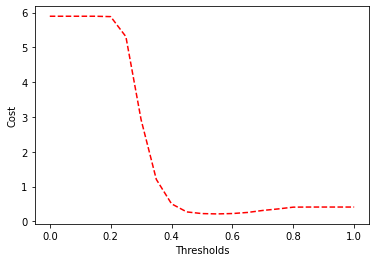

In [109]:
plt.figure(1)
plt.plot(thresholds,  cost_list, 'r--')
plt.xlabel("Thresholds")
plt.ylabel("Cost")
plt.show()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

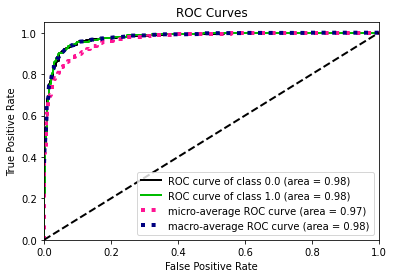

In [132]:
plot_roc(y_test, prob)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

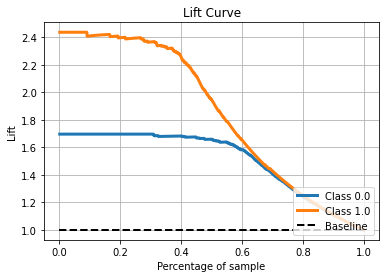

In [133]:
plot_lift_curve(y_test, prob)

The cost-based model training decreases the other performance metrics of the model except for recall of class-0 and precision of class-1. 